# Flight Price Predictions

This dataset contains information about flight prices and various features that might affect them. The data includes:

- Flight routes between different cities in India
- Various airlines
- Flight timings (departure and arrival)
- Duration of flights
- Additional information like number of stops
- Price of the flight tickets (target variable)

The goal is to analyze these features and build a prediction model for flight prices.


In [126]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

## Initial Data Loading

Import pandas library for data manipulation


In [127]:
df = pd.read_csv("./data/flight_price.csv")
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Load and Preview Dataset

Load the flight price dataset from CSV and display first few rows


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [129]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


## Feature Engineering of Dataset


In [130]:
df["Date"] = df["Date_of_Journey"].str.split("/").str[0]
df["Month"] = df["Date_of_Journey"].str.split("/").str[1]
df["Year"] = df["Date_of_Journey"].str.split("/").str[2]

## Date Feature Engineering

Split the Date_of_Journey column into separate Date, Month, and Year columns


In [131]:
df["Date"] = df["Date"].astype(int)
df["Month"] = df["Month"].astype(int)
df["Year"] = df["Year"].astype(int)

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
 11  Date             10683 non-null  int32 
 12  Month            10683 non-null  int32 
 13  Year             10683 non-null  int32 
dtypes: int32(3), int64(1), object(10)
memory usage: 1.0+ MB


In [133]:
df = df.drop("Date_of_Journey", axis=1)

In [134]:
df["Arrival_Time"] = df["Arrival_Time"].apply(lambda x: x.split(" ")[0])

## Arrival Time Processing

Clean and extract the arrival time information


In [135]:
df["Arrival_Hour"] = df["Arrival_Time"].str.split(":").str[0]
df["Arrival_Minute"] = df["Arrival_Time"].str.split(":").str[1]

df["Arrival_Hour"] = df["Arrival_Hour"].astype(int)
df["Arrival_Minute"] = df["Arrival_Minute"].astype(int)

In [136]:
df = df.drop("Arrival_Time", axis=1)

In [137]:
df["Dep_Hour"] = df["Dep_Time"].str.split(":").str[0]
df["Dep_Minute"] = df["Dep_Time"].str.split(":").str[1]

df["Dep_Hour"] = df["Dep_Hour"].astype(int)
df["Dep_Minute"] = df["Dep_Minute"].astype(int)

## Departure Time Processing

Extract hour and minute from departure time


In [138]:
df = df.drop("Dep_Time", axis=1)

In [139]:
df["Duration_in_Minutes"] = df["Duration"].str.extract(r"(\d+)h").fillna(0).astype(
    int
) * 60 + df["Duration"].str.extract(r"(\d+)m").fillna(0).astype(int)

## Duration Processing

Convert duration from string format (hours and minutes) to total minutes


In [140]:
df = df.drop("Duration", axis=1)

## Categorical Data Processing


In [141]:
df["Total_Stops"].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', nan, '4 stops'],
      dtype=object)

In [142]:
df[df["Total_Stops"].isnull()]

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Date,Month,Year,Arrival_Hour,Arrival_Minute,Dep_Hour,Dep_Minute,Duration_in_Minutes
9039,Air India,Delhi,Cochin,NaN,NaN,No info,7480,6,5,2019,9,25,9,45,1420


In [143]:
df["Total_Stops"] = df["Total_Stops"].map(
    {"1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4, "non-stop": 0, np.nan: 1}
)

#### Removing Route because i have alternative features.


In [144]:
df = df.drop("Route", axis=1)

In [145]:
# one hot encoding
encoder = OneHotEncoder()

encoded_df = pd.DataFrame(
    encoder.fit_transform(df[["Airline", "Source", "Destination"]]).toarray(),
    columns=encoder.get_feature_names_out(),
)

In [146]:
df = df.drop(["Airline", "Source", "Destination"], axis=1)

In [149]:
df = pd.concat([encoded_df, df], axis=1)

In [150]:
df.head()

,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,...,Additional_Info,Price,Date,Month,Year,Arrival_Hour,Arrival_Minute,Dep_Hour,Dep_Minute,Duration_in_Minutes
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,No info,3897,24,3,2019,1,10,22,20,170
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,No info,7662,1,5,2019,13,15,5,50,445
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,No info,13882,9,6,2019,4,25,9,25,1140
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,No info,6218,12,5,2019,23,30,18,5,325
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,No info,13302,1,3,2019,21,35,16,50,285


In [151]:
df.describe()

,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,...,Total_Stops,Price,Date,Month,Year,Arrival_Hour,Arrival_Minute,Dep_Hour,Dep_Minute,Duration_in_Minutes
count,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,...,10683.000000,10683.000000,10683.000000,10683.000000,10683.0,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000
mean,0.029861,0.163999,0.018160,0.192174,0.360292,0.000562,0.111954,0.001217,0.076570,0.000094,...,0.824207,9087.064121,13.508378,4.708602,2019.0,13.348778,24.690630,12.490686,24.411214,643.093232
std,0.170210,0.370292,0.133535,0.394028,0.480108,0.023693,0.315324,0.034864,0.265921,0.009675,...,0.675199,4611.359167,8.479277,1.164357,0.0,6.859125,16.506036,5.748650,18.767980,507.862001
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1759.000000,1.000000,3.000000,2019.0,0.000000,0.000000,0.000000,0.000000,5.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5277.000000,6.000000,3.000000,2019.0,8.000000,10.000000,8.000000,5.000000,170.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,8372.000000,12.000000,5.000000,2019.0,14.000000,25.000000,11.000000,25.000000,520.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,12373.000000,21.000000,6.000000,2019.0,19.000000,35.000000,18.000000,40.000000,930.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,79512.000000,27.000000,6.000000,2019.0,23.000000,55.000000,23.000000,55.000000,2860.000000


## Data Visualization Analysis

Let's create some visualizations to better understand our flight price dataset patterns.


In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
sns.set_palette("husl")

# Figure size for all plots
plt.rcParams["figure.figsize"] = [12, 6]

### 1. Price Distribution Analysis

Let's first look at the overall distribution of flight prices and how they vary by different factors.


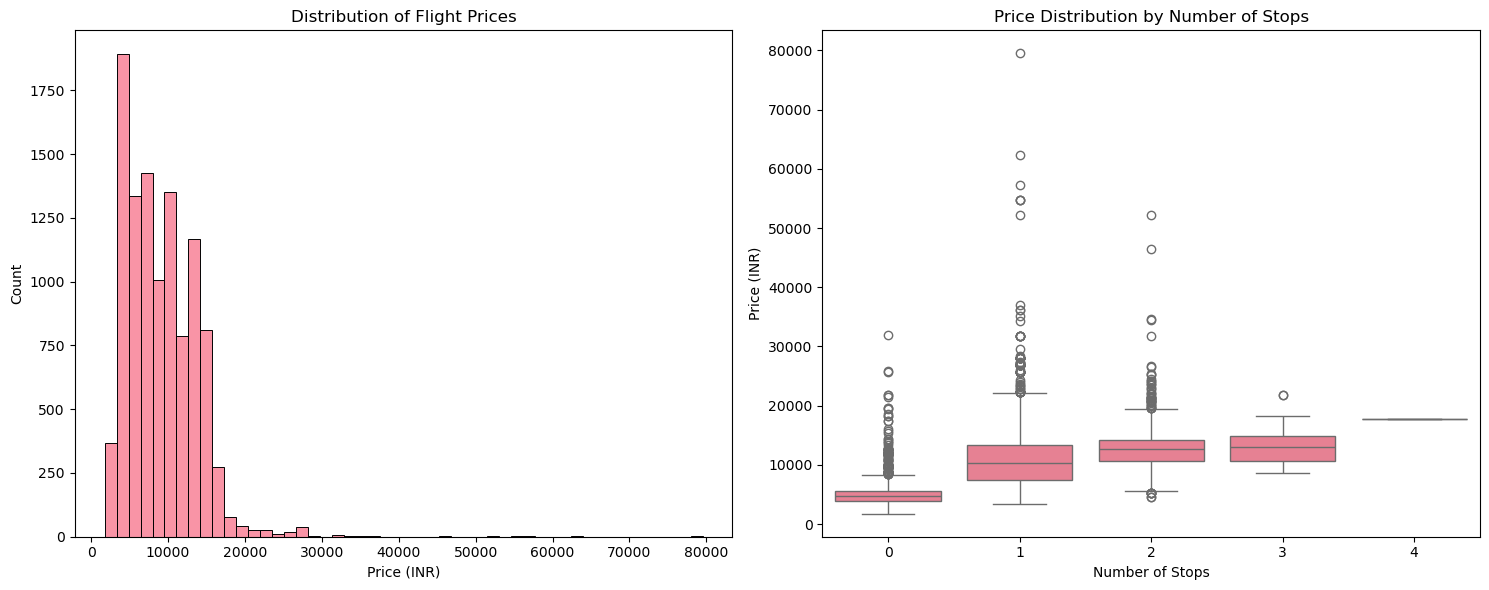

In [156]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Distribution of prices
sns.histplot(data=df, x="Price", bins=50, ax=ax1)
ax1.set_title("Distribution of Flight Prices")
ax1.set_xlabel("Price (INR)")
ax1.set_ylabel("Count")

# Plot 2: Box plot of prices vs stops
sns.boxplot(data=df, x="Total_Stops", y="Price", ax=ax2)
ax2.set_title("Price Distribution by Number of Stops")
ax2.set_xlabel("Number of Stops")
ax2.set_ylabel("Price (INR)")

plt.tight_layout()
plt.show()

### 2. Temporal Analysis

Let's analyze how prices vary across different times of the day and months.


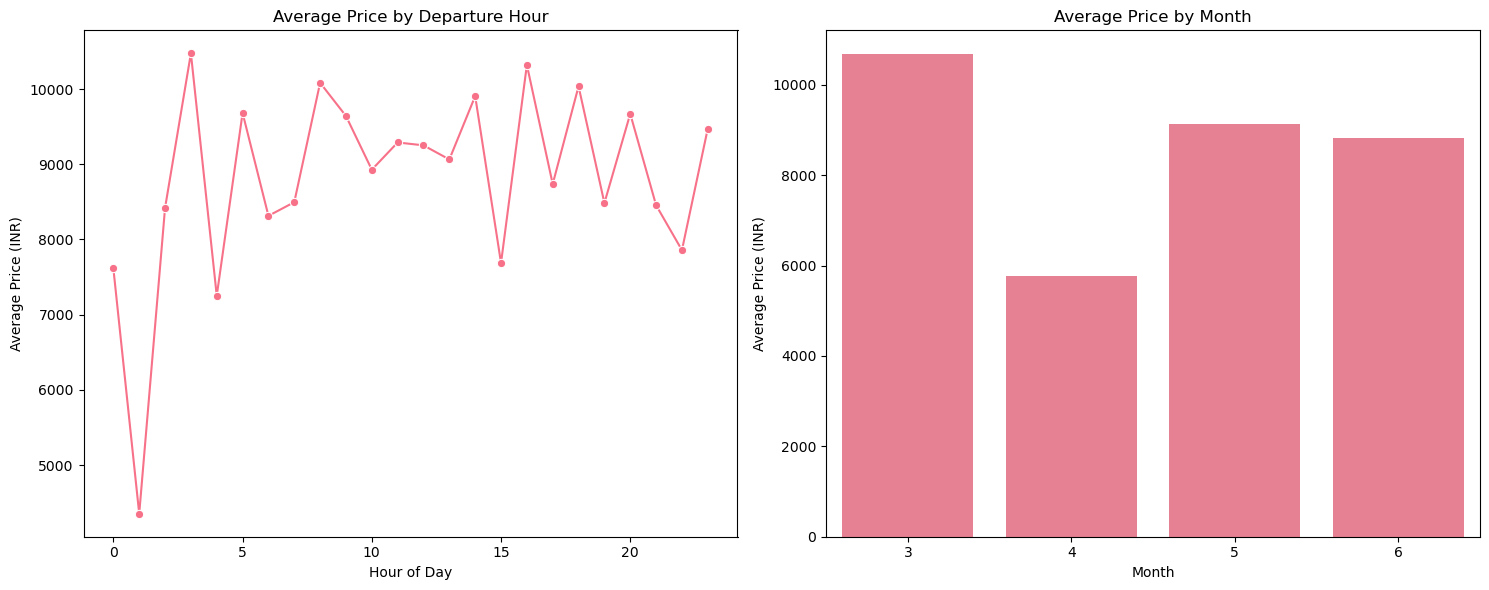

In [157]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Average price by departure hour
hourly_prices = df.groupby("Dep_Hour")["Price"].mean().reset_index()
sns.lineplot(data=hourly_prices, x="Dep_Hour", y="Price", ax=ax1, marker="o")
ax1.set_title("Average Price by Departure Hour")
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Average Price (INR)")

# Plot 2: Monthly price trends
monthly_prices = df.groupby("Month")["Price"].mean().reset_index()
sns.barplot(data=monthly_prices, x="Month", y="Price", ax=ax2)
ax2.set_title("Average Price by Month")
ax2.set_xlabel("Month")
ax2.set_ylabel("Average Price (INR)")

plt.tight_layout()
plt.show()

### 3. Duration Impact Analysis

Let's examine how flight duration affects prices and its relationship with stops.


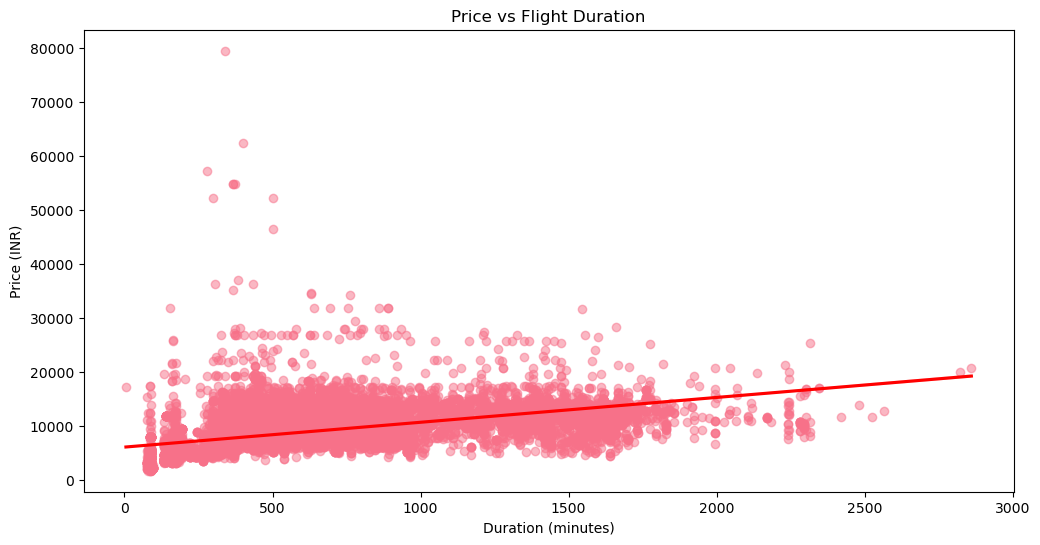

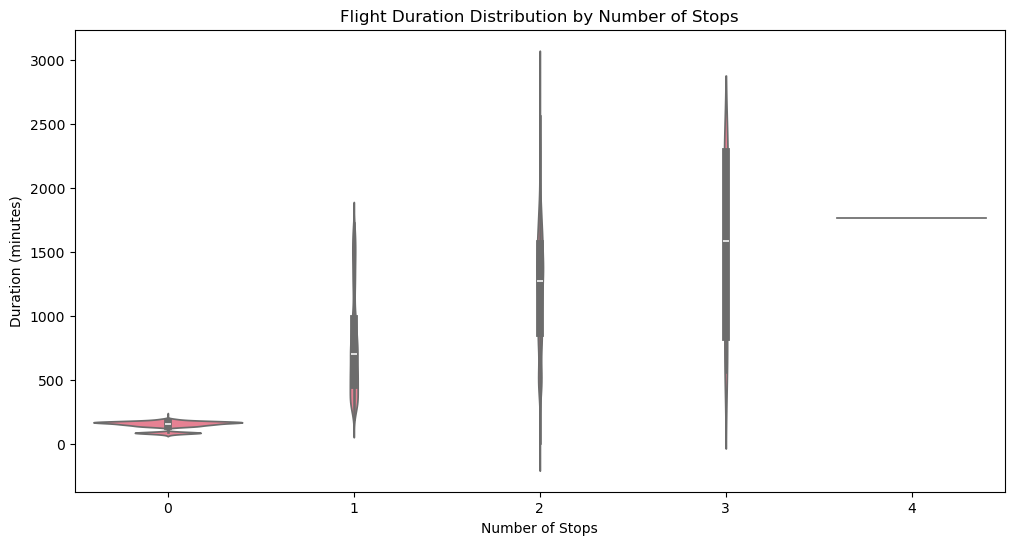

In [161]:
# Create scatter plot with regression line
plt.figure(figsize=(12, 6))
sns.regplot(
    data=df,
    x="Duration_in_Minutes",
    y="Price",
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"},
)
plt.title("Price vs Flight Duration")
plt.xlabel("Duration (minutes)")
plt.ylabel("Price (INR)")
plt.show()

# Create violin plot for price distribution by stops
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x="Total_Stops", y="Duration_in_Minutes")
plt.title("Flight Duration Distribution by Number of Stops")
plt.xlabel("Number of Stops")
plt.ylabel("Duration (minutes)")
plt.show()

### 4. Source-Destination Analysis

Let's analyze the price variations between different city pairs.


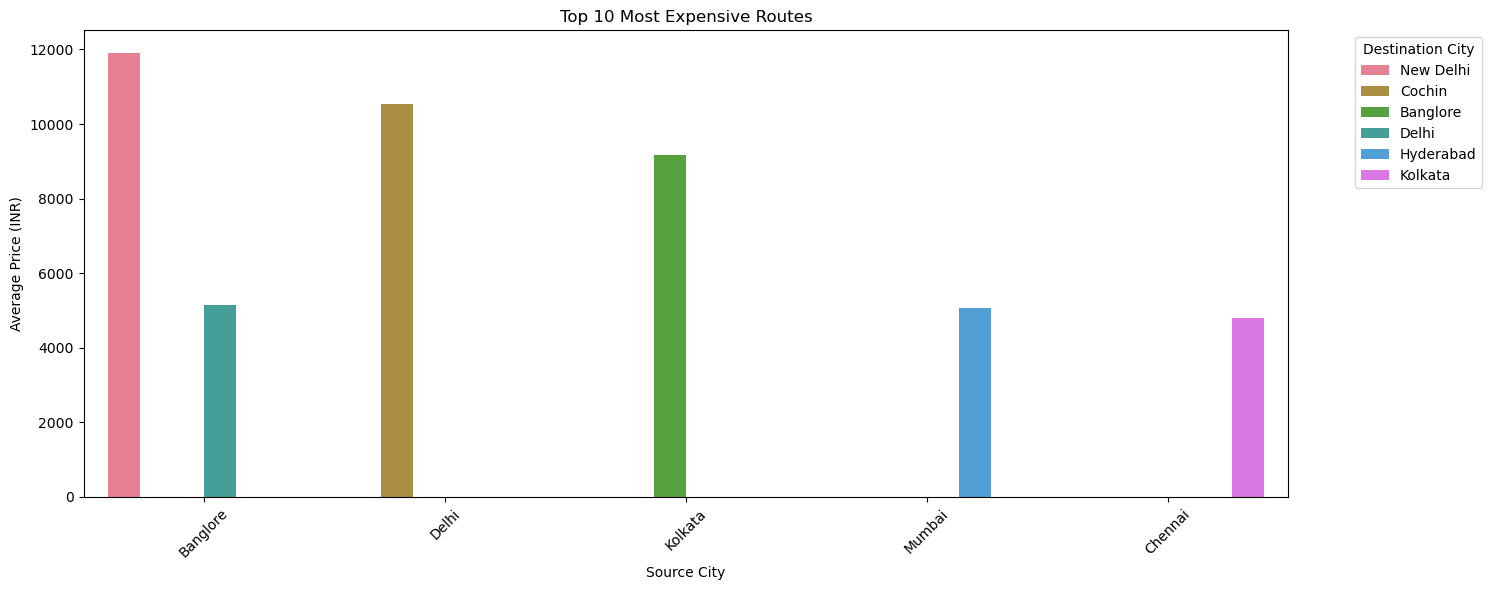

In [162]:
# Get top 10 most expensive routes
source_cols = [col for col in df.columns if col.startswith("Source_")]
dest_cols = [col for col in df.columns if col.startswith("Destination_")]

# Create a DataFrame with route information
route_prices = pd.DataFrame()
for src in source_cols:
    for dst in dest_cols:
        mask = (df[src] == 1) & (df[dst] == 1)
        if mask.sum() > 0:
            avg_price = df[mask]["Price"].mean()
            route_prices = pd.concat(
                [
                    route_prices,
                    pd.DataFrame(
                        {
                            "Source": [src.replace("Source_", "")],
                            "Destination": [dst.replace("Destination_", "")],
                            "Average_Price": [avg_price],
                            "Count": [mask.sum()],
                        }
                    ),
                ]
            )

# Sort by average price and get top 10
top_routes = route_prices.sort_values("Average_Price", ascending=False).head(10)

# Plot
plt.figure(figsize=(15, 6))
sns.barplot(data=top_routes, x="Source", y="Average_Price", hue="Destination")
plt.xticks(rotation=45)
plt.title("Top 10 Most Expensive Routes")
plt.xlabel("Source City")
plt.ylabel("Average Price (INR)")
plt.legend(title="Destination City", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### 5. Airline Analysis

Let's compare prices across different airlines and their market presence.


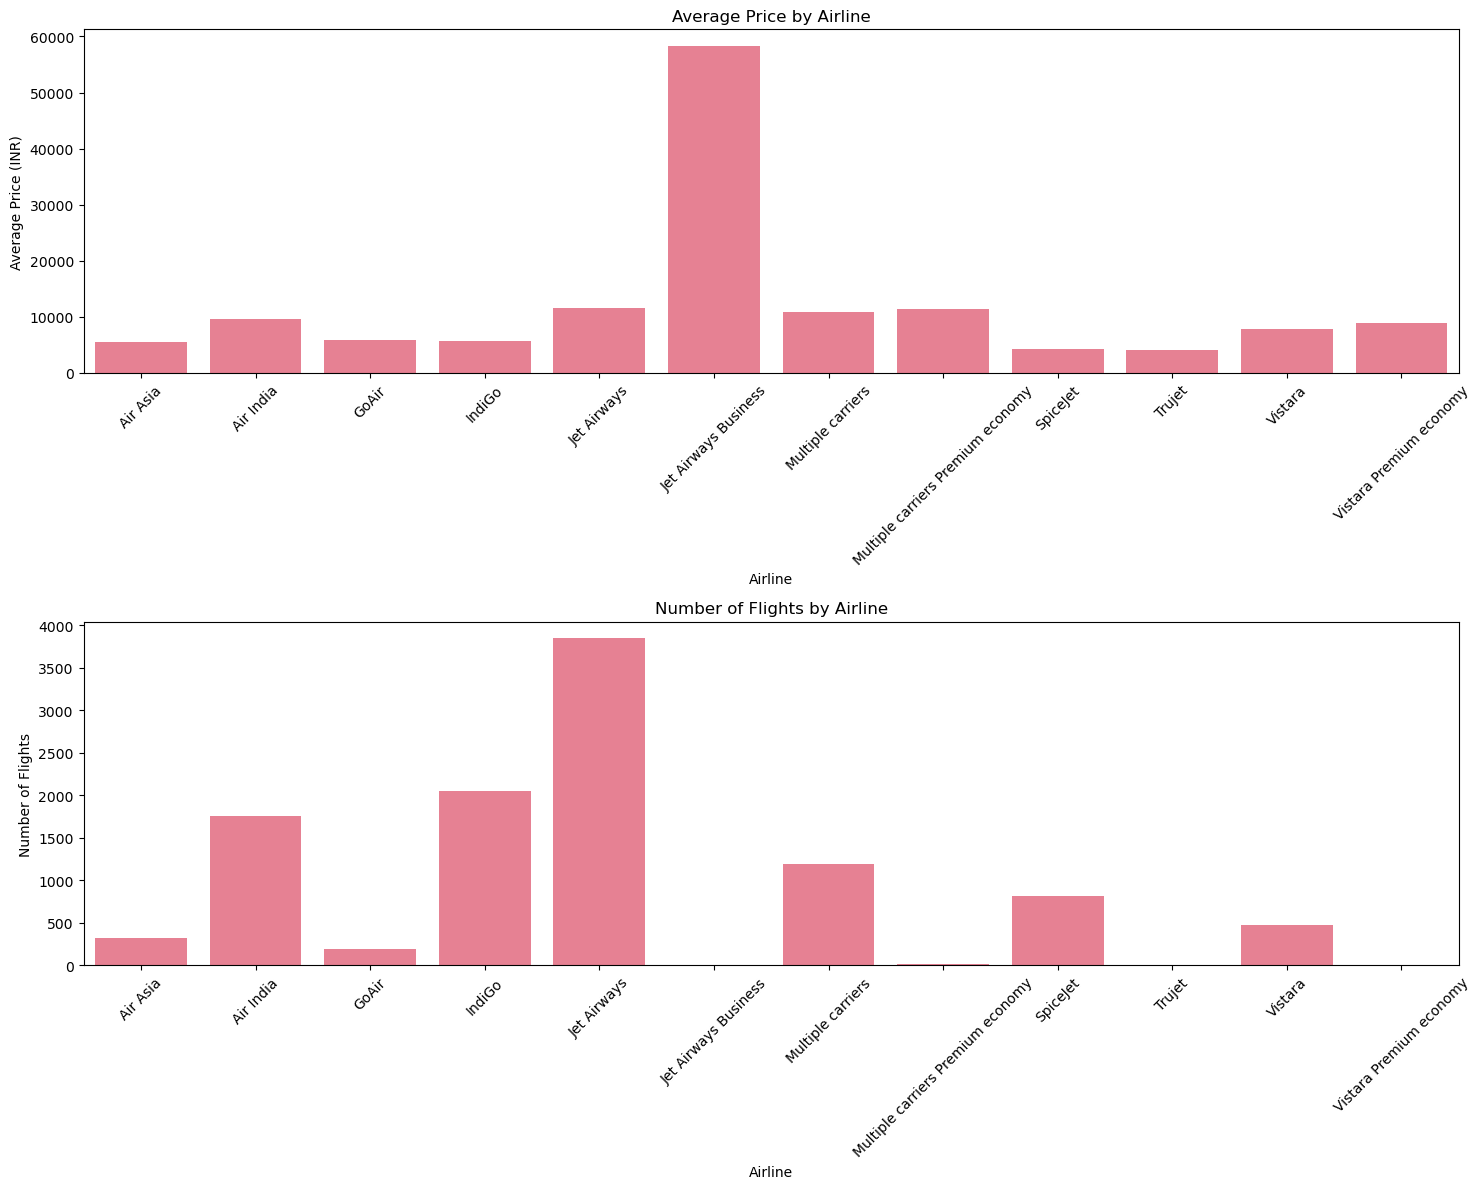

In [163]:
# Get airline columns
airline_cols = [col for col in df.columns if col.startswith("Airline_")]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Average price by airline
airline_prices = []
for col in airline_cols:
    airline_name = col.replace("Airline_", "")
    avg_price = df[df[col] == 1]["Price"].mean()
    airline_prices.append({"Airline": airline_name, "Average_Price": avg_price})

airline_prices_df = pd.DataFrame(airline_prices)
sns.barplot(data=airline_prices_df, x="Airline", y="Average_Price", ax=ax1)
ax1.set_title("Average Price by Airline")
ax1.set_xlabel("Airline")
ax1.set_ylabel("Average Price (INR)")
ax1.tick_params(axis="x", rotation=45)

# Plot 2: Market share (number of flights) by airline
airline_counts = []
for col in airline_cols:
    airline_name = col.replace("Airline_", "")
    count = df[df[col] == 1].shape[0]
    airline_counts.append({"Airline": airline_name, "Flight_Count": count})

airline_counts_df = pd.DataFrame(airline_counts)
sns.barplot(data=airline_counts_df, x="Airline", y="Flight_Count", ax=ax2)
ax2.set_title("Number of Flights by Airline")
ax2.set_xlabel("Airline")
ax2.set_ylabel("Number of Flights")
ax2.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### 6. Correlation Analysis

Finally, let's look at the correlations between numerical features.


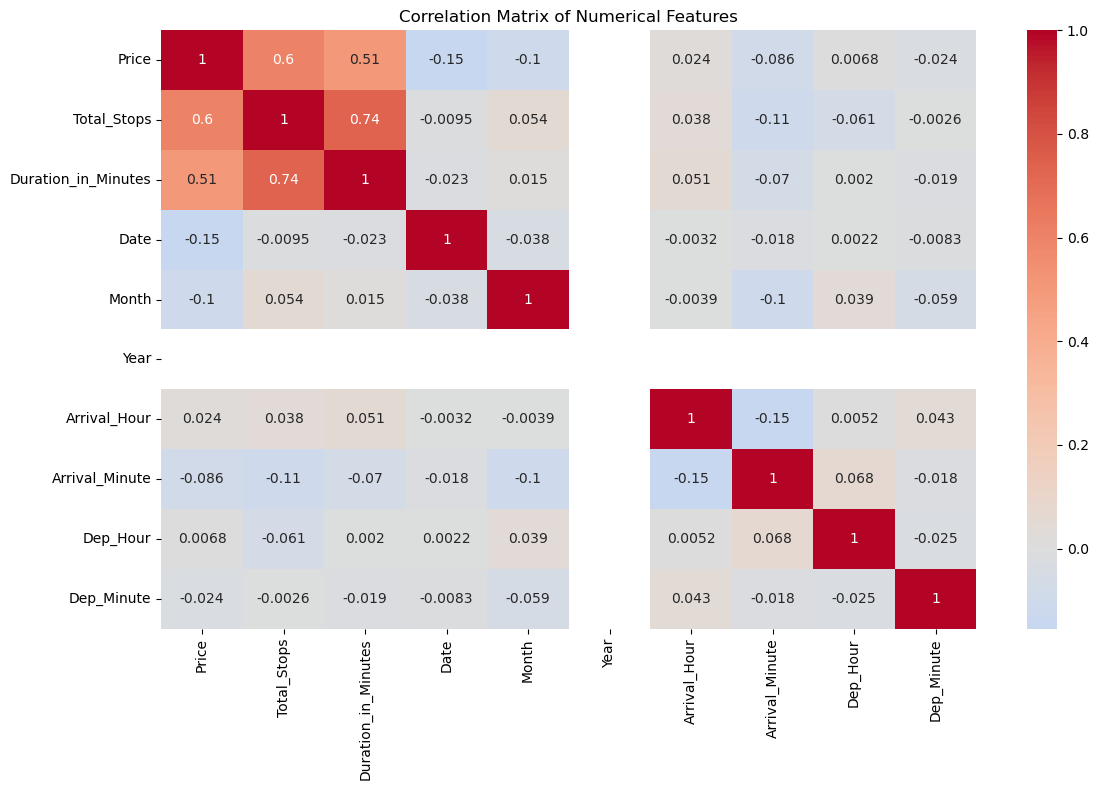

In [164]:
# Select numerical columns
numerical_cols = [
    "Price",
    "Total_Stops",
    "Duration_in_Minutes",
    "Date",
    "Month",
    "Year",
    "Arrival_Hour",
    "Arrival_Minute",
    "Dep_Hour",
    "Dep_Minute",
]

# Calculate correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()